# Mapa autoorganizável - Base Bart e Homer 

## Importando bibliotecas

In [17]:
!pip install -q minisom

In [18]:
# Importacao desta lib para desativar erro no TensorFlow
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [19]:
from minisom import MiniSom
import pandas as pd
import numpy as np

## Carregamento base de dados

In [20]:
base = pd.read_csv('personagens.csv')
base

,laranja_camisa_bart,azul_calcao_bart,azul_sapato_bart,marrom_boca_homer,azul_calca_homer,cinza_sapato_homer,classe
0,6.886102,3.495204,1.484984,0.000000,0.000000,0.062954,Bart
1,5.004901,3.183889,1.000142,0.000000,0.000000,0.033024,Bart
2,5.264620,5.029683,0.283567,0.000000,0.000000,0.151573,Bart
3,0.000000,0.000000,0.000000,0.480168,0.000000,0.021164,Bart
4,8.978929,3.459119,0.000000,0.000000,0.000000,0.011593,Bart
...,...,...,...,...,...,...,...
288,0.000000,0.000000,0.000000,0.000000,6.485412,0.093921,Homer
289,0.000000,0.000000,0.000000,0.000000,0.000000,0.042194,Homer
290,0.000000,0.000000,0.000000,0.000000,4.263629,0.076761,Homer
291,0.000000,0.000000,0.000000,0.000000,1.429134,0.017013,Homer


In [21]:
X = base.iloc[:, 0:6].values
y = base.iloc[:,6].values

## Normalização dos dados - escalonamento

In [22]:
from sklearn.preprocessing import MinMaxScaler
normalizador = MinMaxScaler(feature_range = (0,1))
X = normalizador.fit_transform(X)

## Criação do mapa auto organizável

In [23]:
# Aplicando a fórmula abordada no slide teórico, primeiro tiramos a raíz quadrada
# da quantidade de registros (293), que é igual a 17,11
# Multiplicamos 17,11 por 5 = 85,58
# Vamos definir o mapa auto organizável com as dimensões 9 x 9
# que equivale a 81 neurônios no total
# O input_len possui o valor 6 porque temos 6 entradas
som = MiniSom(x = 9, y = 9, input_len = 6, random_seed = 0,
              learning_rate = 0.5, sigma = 1.0)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 500)

## Visualização dos resultados

In [24]:
# Transformação das classes em números para associarmos com os markers e colors abaixo
y[y == 'Bart'] = 0
y[y == 'Homer'] = 1


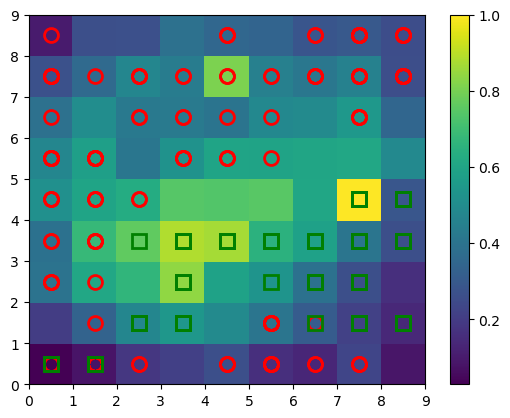

In [25]:
# O código abaixo gera o mapa auto organizável e imprime os símbolos de acordo
# com os valores das classes
from pylab import pcolor, colorbar, plot
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5, w[1] + 0.5, markers[y[i]],
         markerfacecolor = 'None', markersize = 10,
         markeredgecolor = colors[y[i]], markeredgewidth = 2)

## Detecção de registros que podem ser outliers

In [26]:
# Visualizando o mapa acima, detectamos a coordenada (6,2) como a única com 
# possíveis outliers (cor amarela)
mapeamento = som.win_map(X)
suspeitos = mapeamento[(6,2)]
suspeitos = normalizador.inverse_transform(suspeitos)

In [30]:
# Precisamos agora buscar os possíveis outliers e para isso é necessário
# comparar cada uma das características da base original com a base de suspeitos
# Caso tivéssemos um atributo identificador para cada registro bastaria comparar
# o identificador
# Comparação com uma tolerância para evitar problemas de arredondamento
tolerancia = 1e-5  # Tolerância pequena

classe = []
for i in range(len(base)):
    for j in range(len(suspeitos)):
        if (abs(base.iloc[i, 0] - suspeitos[j, 0]) < tolerancia and
            abs(base.iloc[i, 1] - suspeitos[j, 1]) < tolerancia and
            abs(base.iloc[i, 2] - suspeitos[j, 2]) < tolerancia and
            abs(base.iloc[i, 3] - suspeitos[j, 3]) < tolerancia and
            abs(base.iloc[i, 4] - suspeitos[j, 4]) < tolerancia and
            abs(base.iloc[i, 5] - suspeitos[j, 5]) < tolerancia):
            classe.append(base.iloc[i, 6])
classe = np.asarray(classe)

In [31]:
# Caso o tamanho da variável suspeitos seja maior que o tamanho da variável
# classe, verifique o arredondamento dos valores por causa da normalização

# Criação da lista final de suspeitos
# Podemos perceber que de fato todos esses registros saem fora do padrão, pois
# são todas imagens do Homer que não apresentam as características do Homer
suspeitos_final = np.column_stack((suspeitos, classe))
suspeitos_final = suspeitos_final[suspeitos_final[:, 4].argsort()]

In [32]:
suspeitos_final

array([[0.        , 0.        , 0.        , 2.3117392 , 1.3994405 ,
        0.04052894, 1.        ],
       [0.        , 0.        , 0.        , 3.5661027 , 1.448672  ,
        0.00914854, 1.        ]])